### Eliminación de ruido

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [41]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)    

In [42]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [43]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [44]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [45]:
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [46]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0476
Epoch:2, Loss:0.0417
Epoch:3, Loss:0.0387
Epoch:4, Loss:0.0331
Epoch:5, Loss:0.0392
Epoch:6, Loss:0.0359
Epoch:7, Loss:0.0376
Epoch:8, Loss:0.0377
Epoch:9, Loss:0.0377
Epoch:10, Loss:0.0375


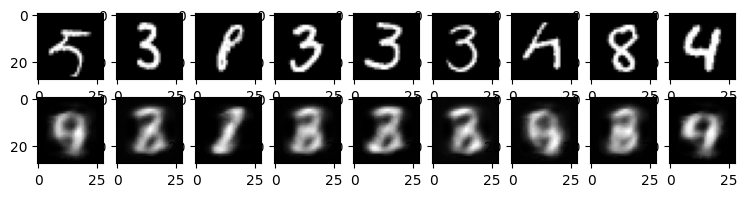

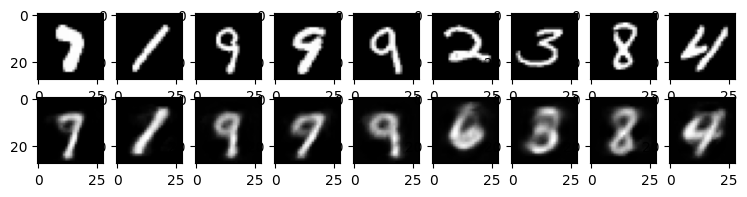

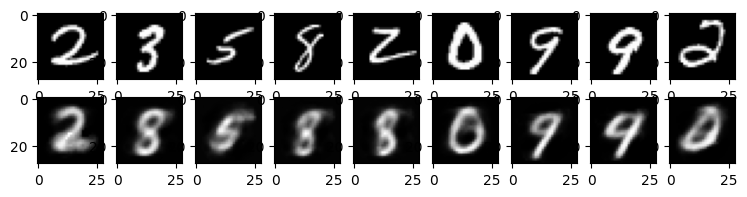

In [47]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

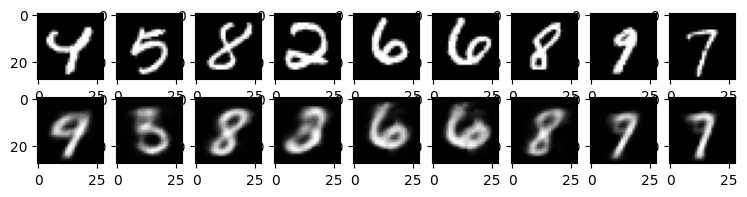

In [48]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img2 = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        pred = model(img2)
        recon = pred[0].detach().numpy()
        recon2 = recon.reshape(-1, 28,28) # -> use for Autoencoder_Linear

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon2[0])

### Superresolución

In [50]:
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)

In [51]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [52]:
def add_gaussian_noise(images, noise_factor=0.3):
    """
    Añade ruido gaussiano a las imágenes
    noise_factor: controla la cantidad de ruido (típicamente entre 0.1 y 0.5)
    """
    noisy_images = images + noise_factor * torch.randn_like(images)
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

In [53]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [54]:
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [55]:
num_epochs = 10
noise_factor = 0.3  # Ajusta este valor
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # Preparar imágenes limpias
        img_clean = img.reshape(-1, 28*28)
        
        # Añadir ruido a las imágenes de entrada
        img_noisy = add_gaussian_noise(img, noise_factor)
        img_noisy = img_noisy.reshape(-1, 28*28)
        
        # Forward: entrada con ruido, objetivo sin ruido
        recon = model(img_noisy)
        loss = criterion(recon, img_clean)  # Comparar con imagen limpia
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img_clean, img_noisy, recon))

Epoch:1, Loss:0.0505
Epoch:2, Loss:0.0494
Epoch:3, Loss:0.0367
Epoch:4, Loss:0.0466
Epoch:5, Loss:0.0403
Epoch:6, Loss:0.0314
Epoch:7, Loss:0.0375
Epoch:8, Loss:0.0346
Epoch:9, Loss:0.0337
Epoch:10, Loss:0.0371


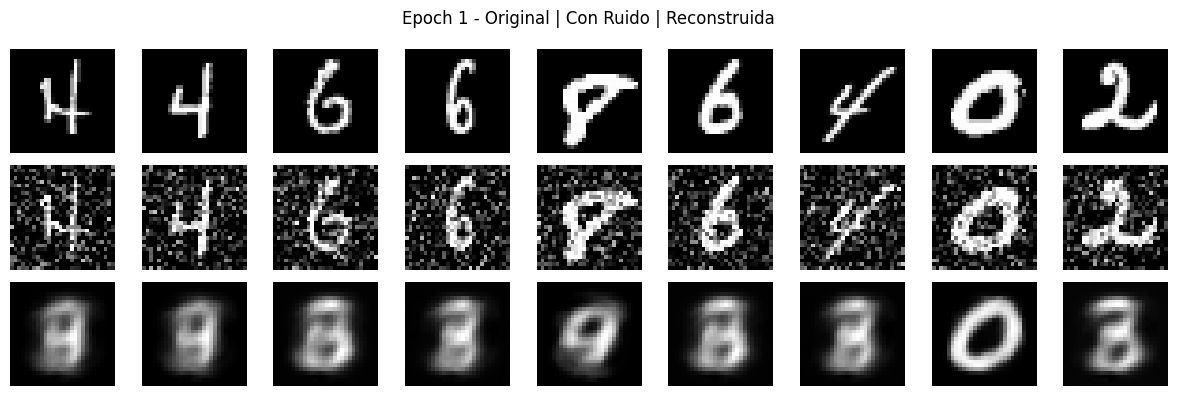

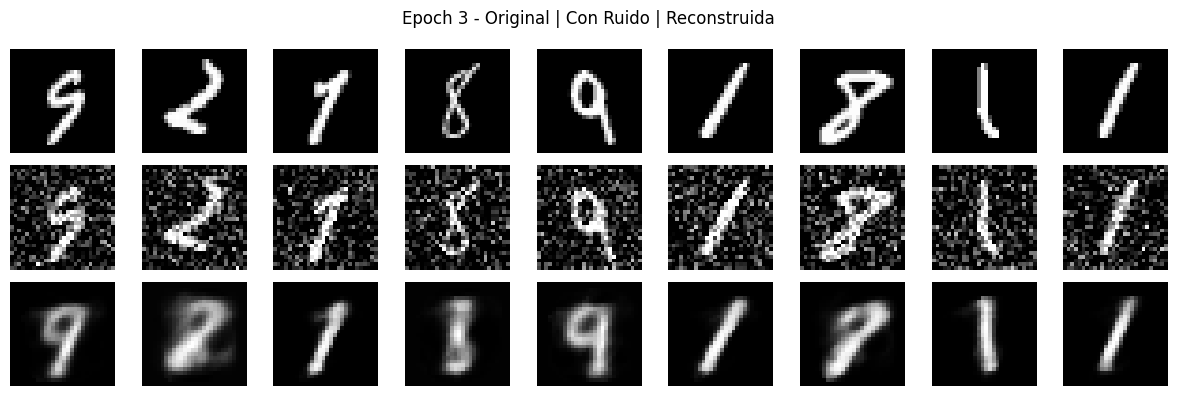

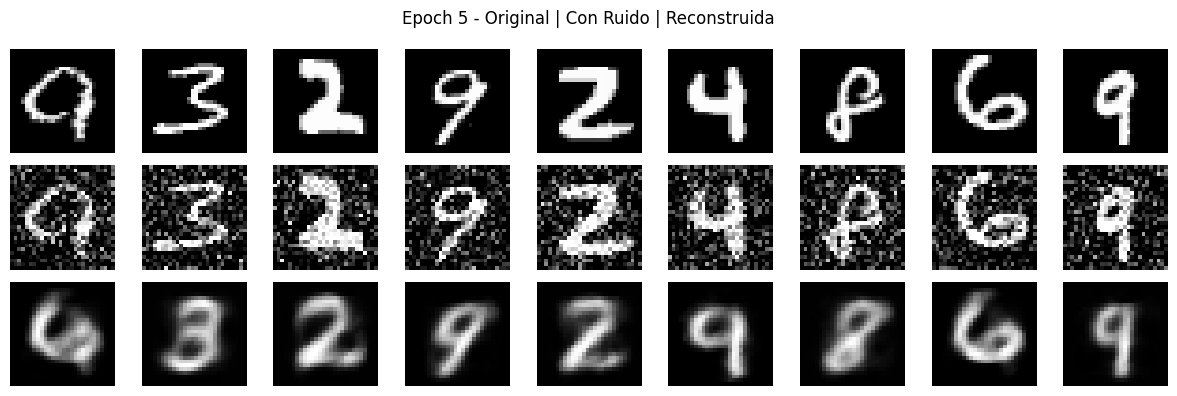

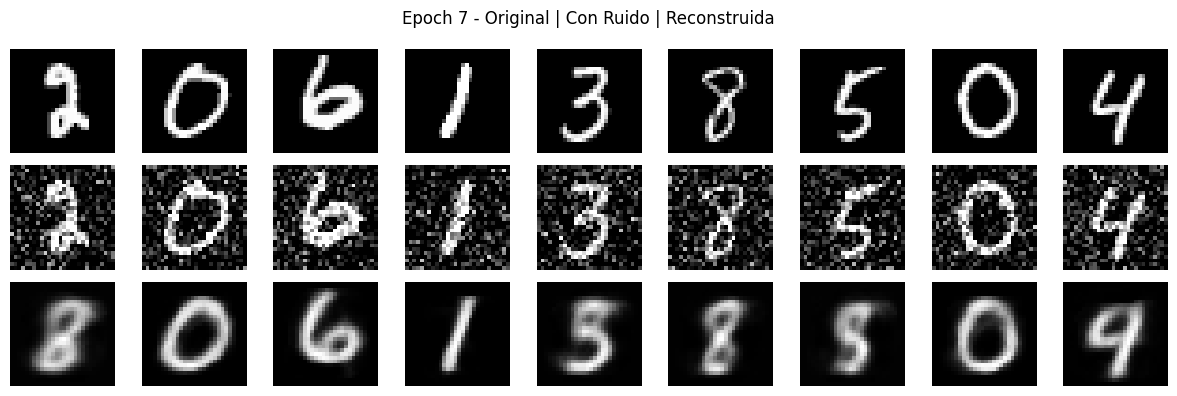

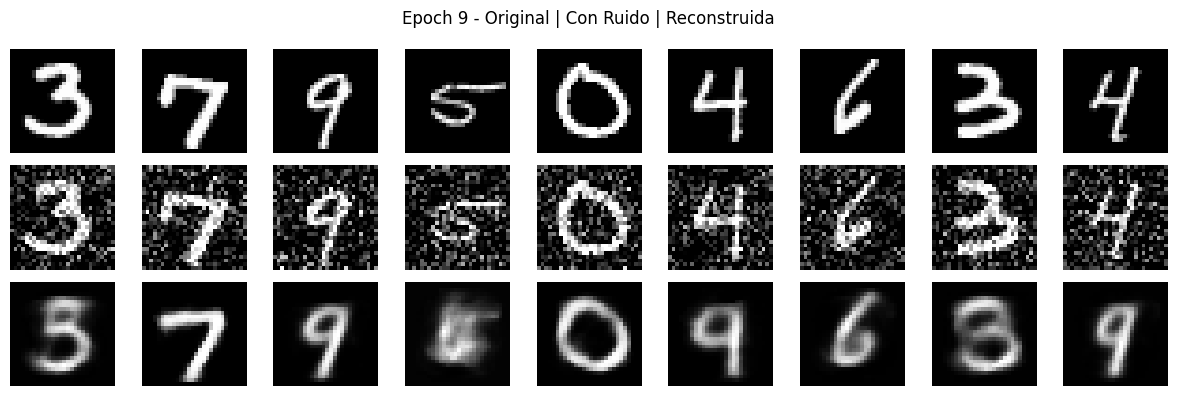

In [56]:
for k in range(0, num_epochs, 2):
    plt.figure(figsize=(12, 4))
    plt.gray()
    
    imgs_clean = outputs[k][1].detach().numpy()
    imgs_noisy = outputs[k][2].detach().numpy()
    recon = outputs[k][3].detach().numpy()

    # Fila 1: Originales
    for i in range(9):
        plt.subplot(3, 9, i+1)
        item = imgs_clean[i].reshape(28, 28)
        plt.imshow(item)
        plt.axis('off')
    
    # Fila 2: Con ruido
    for i in range(9):
        plt.subplot(3, 9, 9+i+1)
        item = imgs_noisy[i].reshape(28, 28)
        plt.imshow(item)
        plt.axis('off')
            
    # Fila 3: Reconstruidas
    for i in range(9):
        plt.subplot(3, 9, 18+i+1)
        item = recon[i].reshape(28, 28)
        plt.imshow(item)
        plt.axis('off')
    
    plt.suptitle(f'Epoch {k+1} - Original | Con Ruido | Reconstruida')
    plt.tight_layout()
    plt.show()

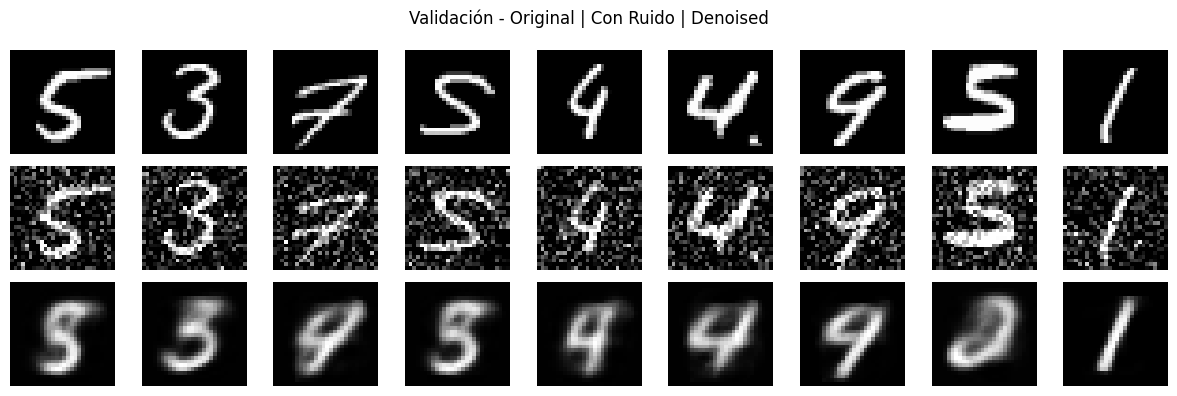

In [57]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

plt.figure(figsize=(12, 4))
plt.gray()

for i in range(9):
    with torch.no_grad():
        img_clean = images[i]
        
        # Añadir ruido
        img_noisy = add_gaussian_noise(img_clean.unsqueeze(0), noise_factor)
        img_noisy_flat = img_noisy.reshape(-1, 28*28)
        
        # Reconstrucción
        pred = model(img_noisy_flat)
        recon = pred[0].detach().numpy().reshape(28, 28)
        
        # Fila 1: Original
        plt.subplot(3, 9, i+1)
        plt.imshow(img_clean[0])
        plt.axis('off')
        
        # Fila 2: Con ruido
        plt.subplot(3, 9, i+10)
        plt.imshow(img_noisy[0][0])
        plt.axis('off')
        
        # Fila 3: Reconstruida (denoised)
        plt.subplot(3, 9, i+19)
        plt.imshow(recon)
        plt.axis('off')

plt.suptitle('Validación - Original | Con Ruido | Denoised')
plt.tight_layout()
plt.show()

In [58]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader_valid = torch.utils.data.DataLoader(mnist_data_valid, batch_size=64, shuffle=True)

In [59]:
def downsample_image(images, size):
    """
    Reduce la resolución de imágenes 28x28 a size x size
    size: 7 o 14
    """
    return F.interpolate(images, size=(size, size), mode='bilinear', align_corners=False)

In [60]:
class SuperResolution_7to28(nn.Module):
    def __init__(self):
        super().__init__()
        # Entrada: (N, 1, 7, 7)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),     # (N, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),    # (N, 64, 7, 7)
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # (N, 32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # (N, 16, 28, 28)
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1),                      # (N, 1, 28, 28)
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [61]:
class SuperResolution_14to28(nn.Module):
    def __init__(self):
        super().__init__()
        # Entrada: (N, 1, 14, 14)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),     # (N, 32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),    # (N, 64, 14, 14)
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # (N, 32, 28, 28)
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),                      # (N, 1, 28, 28)
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [62]:
class SuperResolution_Linear_7to28(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(7 * 7, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [63]:
model = SuperResolution_7to28()
input_size = 7

In [64]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print(f'Modelo: {input_size}x{input_size} → 28x28')

Modelo: 7x7 → 28x28


In [ ]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    total_loss = 0
    for img, _ in data_loader:
        # img original: (N, 1, 28, 28)
        img_high_res = img  # Imagen objetivo (alta resolución)
        
        # Crear imagen de baja resolución
        img_low_res = downsample_image(img, input_size)  # (N, 1, input_size, input_size)
        
        # Para modelo lineal, aplanar
        if isinstance(model, SuperResolution_Linear_7to28):
            img_low_res = img_low_res.reshape(-1, input_size * input_size)
            img_high_res = img_high_res.reshape(-1, 28 * 28)
        
        # Forward pass: entrada baja resolución, objetivo alta resolución
        recon = model(img_low_res)
        loss = criterion(recon, img_high_res)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(data_loader)
    print(f'Epoch:{epoch+1}, Loss:{avg_loss:.4f}')
    
    # Guardar para visualización
    if isinstance(model, SuperResolution_Linear_7to28):
        img_low_res_vis = img_low_res.reshape(-1, 1, input_size, input_size)
        img_high_res_vis = img_high_res.reshape(-1, 1, 28, 28)
        recon_vis = recon.reshape(-1, 1, 28, 28)
    else:
        img_low_res_vis = img_low_res
        img_high_res_vis = img_high_res
        recon_vis = recon
    
    outputs.append((img_high_res_vis, img_low_res_vis, recon_vis))

Epoch:1, Loss:0.1135
Epoch:2, Loss:0.1120
Epoch:3, Loss:0.1120
Epoch:4, Loss:0.1120


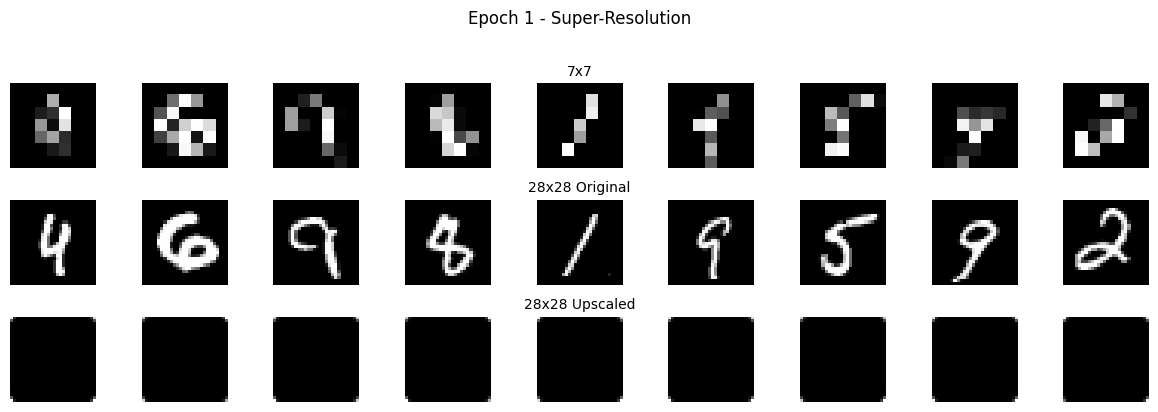

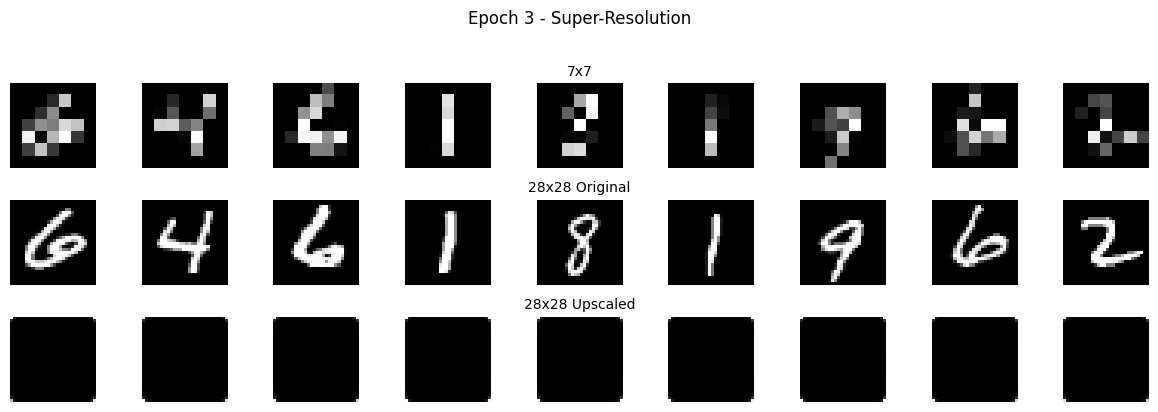

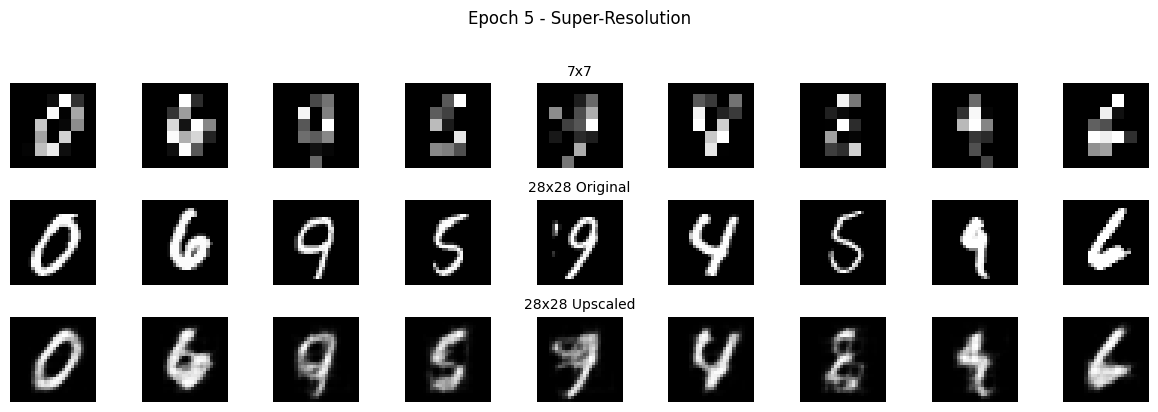

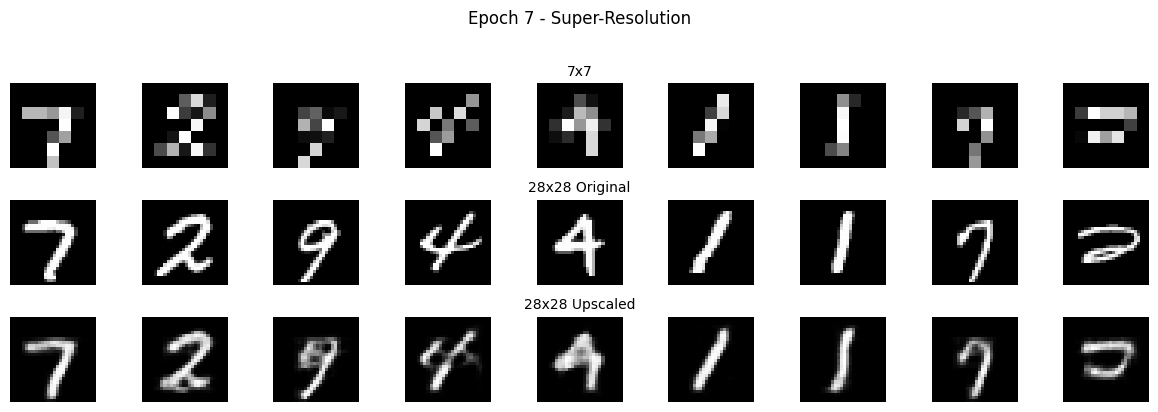

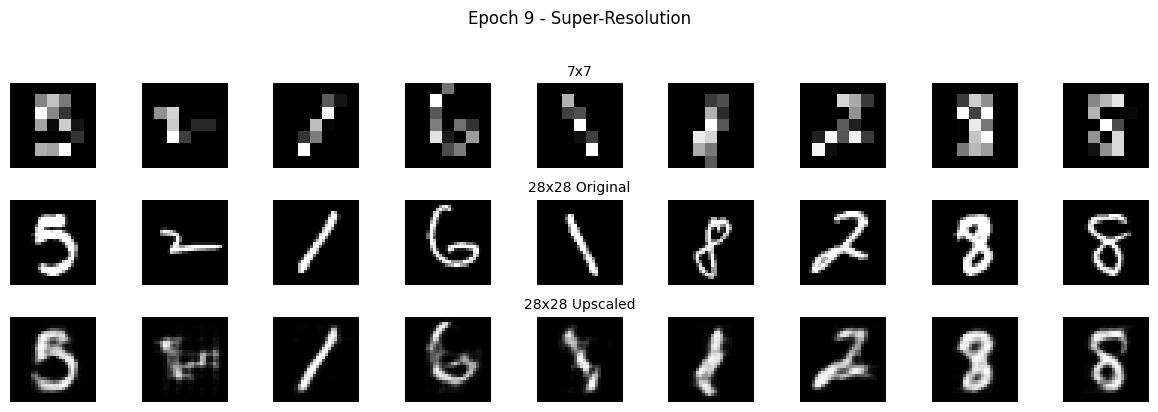

In [ ]:
for k in range(0, num_epochs, 2):
    plt.figure(figsize=(12, 4))
    plt.gray()
    
    img_high, img_low, recon = outputs[k]
    img_high = img_high.detach().cpu()
    img_low = img_low.detach().cpu()
    recon = recon.detach().cpu()

    for i in range(9):
        # Fila 1: Baja resolución (input)
        plt.subplot(3, 9, i+1)
        plt.imshow(img_low[i][0])
        plt.axis('off')
        if i == 4:
            plt.title(f'{input_size}x{input_size}', fontsize=10)
        
        # Fila 2: Alta resolución original (target)
        plt.subplot(3, 9, 9+i+1)
        plt.imshow(img_high[i][0])
        plt.axis('off')
        if i == 4:
            plt.title('28x28 Original', fontsize=10)
        
        # Fila 3: Reconstruida (output)
        plt.subplot(3, 9, 18+i+1)
        plt.imshow(recon[i][0])
        plt.axis('off')
        if i == 4:
            plt.title('28x28 Upscaled', fontsize=10)
    
    plt.suptitle(f'Epoch {k+1} - Super-Resolution', y=1.02)
    plt.tight_layout()
    plt.show()

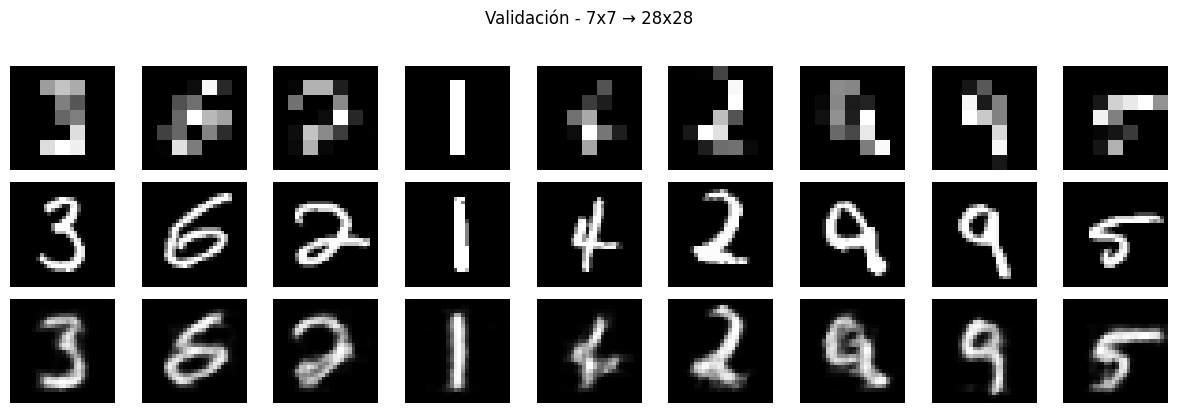

In [ ]:
model.eval()
images, _ = next(iter(data_loader_valid))

plt.figure(figsize=(12, 4))
plt.gray()

for i in range(9):
    with torch.no_grad():
        # Imagen original alta resolución
        img_high = images[i]
        
        # Reducir resolución
        img_low = downsample_image(img_high.unsqueeze(0), input_size)
        
        # Para modelo lineal
        if isinstance(model, SuperResolution_Linear_7to28):
            img_low_input = img_low.reshape(-1, input_size * input_size)
            recon = model(img_low_input).reshape(28, 28)
        else:
            recon = model(img_low)[0][0]
        
        # Fila 1: Baja resolución
        plt.subplot(3, 9, i+1)
        plt.imshow(img_low[0][0])
        plt.axis('off')
        
        # Fila 2: Original alta resolución
        plt.subplot(3, 9, i+10)
        plt.imshow(img_high[0])
        plt.axis('off')
        
        # Fila 3: Super-resolution
        plt.subplot(3, 9, i+19)
        plt.imshow(recon)
        plt.axis('off')

plt.suptitle(f'Validación - {input_size}x{input_size} → 28x28', y=1.02)
plt.tight_layout()
plt.show()